In [1]:
# import pickle
import torch
# import torch.nn.functional as F
# # from trainingUtils import MultipleOptimizer, MultipleScheduler, compute_kernel, compute_mmd
# from models import Encoder,Decoder,GaussianDecoder,VAE,CellStateEncoder,\
#                    CellStateDecoder, CellStateVAE,\
#                    SimpleEncoder,LocalDiscriminator,PriorDiscriminator,\
#                    EmbInfomax,MultiEncInfomax,Classifier,\
#                    SpeciesCovariate,GaussianDecoder

import scanpy as sc
# # import argparse
# import math
import numpy as np
import pandas as pd
# from IPython.display import clear_output
# from matplotlib import pyplot as plt
# #from scipy.stats import pearsonr
# from scipy.stats import spearmanr
# from sklearn.model_selection import train_test_split,cross_validate,KFold
# from sklearn.metrics import confusion_matrix
# from sklearn.neighbors import KNeighborsClassifier
# from evaluationUtils import r_square,get_cindex,pearson_r,pseudoAccuracy
# import seaborn as sns
# sns.set()

In [18]:
# # human lung
# human = sc.read_h5ad('human lung fibrosis/Habermann_ild_subset_raw.h5ad')
# human.var

In [17]:
# # mouse lung
# mouse = pd.read_csv('human lung fibrosis/Strunz_2020_raw.csv',index_col=0)
# mouse

In [2]:
device = torch.device('cuda')

In [3]:
# Create a train generators
def getSamples(N, batchSize):
    order = np.random.permutation(N)
    outList = []
    while len(order)>0:
        outList.append(order[0:batchSize])
        order = order[batchSize:]
    return outList

In [5]:
# human = sc.read_h5ad('human_liver_fibrosis.h5ad')
# human.to_df()
human_liver = pd.read_csv('human_liver_fibrosis.csv',index_col=0)
human_liver

KeyboardInterrupt: 

In [ ]:
human_liver_categories = pd.read_csv('human_liver_fibrosis_categories.csv',index_col=0)
human_liver_categories

### Load data

In [2]:
# Human data
#human = sc.read_h5ad('human_processed.h5ad')
human = sc.read_h5ad('human lung fibrosis/Habermann_ild_subset_raw.h5ad')
human.layers["raw_counts"] = human.X.copy()
# sc.pp.normalize_total(human) # for lung
# sc.pp.normalize_total(human, target_sum=1e4, exclude_highly_expressed=True)
# sc.pp.log1p(human)
# sc.pp.highly_variable_genes(human,n_top_genes=10000, subset=True) # for lung
# sc.pp.pca(human)
human_df = human.to_df()
human_df['Diagnosis'] = 1*(human.obs['Diagnosis']=='IPF')
human_df['Species'] = 'human'
human_df['cell_type'] = 1
for i in range(len(human.obs)):
    if human.obs['Population'][i]=='Immune':
        human_df['cell_type'][i] = 1
    elif human.obs['Population'][i]=='Mesenchymal':
        human_df['cell_type'][i] = 2
    elif human.obs['Population'][i]=='Epithelial':
        human_df['cell_type'][i] = 3
    else:
        human_df['cell_type'][i] = 4
releventGenes = list(human_df.columns[np.where(human_df.iloc[:,:-3].sum(axis=0) != 0)])
human_df = human_df.loc[:,releventGenes+['Diagnosis','Species','cell_type']]
human_df

<ipython-input-2-bab9e97dde35>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  human_df['cell_type'][i] = 3
<ipython-input-2-bab9e97dde35>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  human_df['cell_type'][i] = 1
<ipython-input-2-bab9e97dde35>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  human_df['cell_type'][i] = 4
<ipython-input-2-bab9e97dde35>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

,RP11-34P13.7,RP11-34P13.14,FO538757.3,FO538757.2,AP006222.2,RP5-857K21.15,RP4-669L17.2,RP4-669L17.10,RP5-857K21.4,RP11-206L10.9,...,AL354822.1,AC023491.2,AC004556.1,AC233755.2,AC233755.1,AC240274.1,AC213203.1,Diagnosis,Species,cell_type
F01157_AAACCTGAGCATCATC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,human,3
F01157_AAACCTGTCATGCTCC,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,human,3
F01157_AAACGGGGTTACGACT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,human,3
F01157_AAACGGGGTTAGTGGG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,human,3
F01157_AAACGGGTCCTTTCGG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,human,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
F01380_TTTGGTTGTATAGGGC,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,human,1
F01380_TTTGGTTTCACCACCT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,human,1
F01380_TTTGGTTTCATCGGAT,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,human,3
F01380_TTTGTCAAGAGTTGGC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,human,2


In [5]:
# human = sc.read_h5ad('human_processed.h5ad')
# sc.pp.normalize_total(human, target_sum=1e4, exclude_highly_expressed=True)
# sc.pp.log1p(human)
# sc.pp.pca(human)
# sc.tl.rank_genes_groups(human, groupby='Diagnosis', method='wilcoxon',use_raw=False)

In [6]:
# plt.hist(human.uns['rank_genes_groups']['scores']['Control'])

In [4]:
# Mouse Data
# Immune 1
# Mesenchymal 2
# Epithelial 3
# Endothelial 4
# Stem cells 5 # or mesothelia_cells in the lung dataset

# immune_mouse = ['Macrophages','T cells','B cells','DC','Monocytes','Tgd','NKT','Neutrophils',
#                                    'NK cells','Mast cells','Basophils','ILC']
# mesench_mouse = ['Fibroblasts','Stromal cells']
# epith_mouse = ['Epithelial cells']
# endo_mouse = ['Endothelial cells']

### This bellow is for the lung dataset
immune_mouse = ['macrophages','T_cells','B_cells','dendritic_cells','monocytes','granulocytes',
                                   'NK_cells','Mast cells','Basophils','ILC']
mesench_mouse = ['fibroblasts','Stromal cells']
epith_mouse = ['alv_epithelium','goblet_cells','club_cells','ciliated_cells']
endo_mouse = ['endothelial_cells']

# mouse = sc.read_h5ad('mouse_processed.h5ad')
mouse = sc.read_h5ad('human lung fibrosis/Strunz_2020_raw.h5ad')
# sc.pp.normalize_total(mouse) # for lung
# sc.pp.log1p(mouse) # for lung
# sc.pp.highly_variable_genes(mouse,n_top_genes=10000, subset=True) # for lung
# sc.pp.pca(mouse)

mouse_df = mouse.to_df()
original_mouse = mouse.obs
keep = [x not in ['smooth_muscle_cells','unassigned'] for x in mouse.obs['metacelltype']]

mouse_df = mouse_df[keep]
original_mouse = original_mouse[keep]
# mouse_df['Diagnosis'] = [1*("Bleomycin" in i) for i in mouse.obs['orig.ident']]
mouse_df['Diagnosis'] = [1*("Bleo" in i) for i in original_mouse['identifier']]
mouse_df['Species'] = 'mouse'
mouse_df['cell_type'] = 1
# for i in range(len(mouse.obs)):
#     if mouse.obs['broad.cell.type'][i] in immune_mouse:
#         mouse_df['cell_type'][i]= 1
#     elif mouse.obs['broad.cell.type'][i] in mesench_mouse:
#         mouse_df['cell_type'][i]= 2
#     elif mouse.obs['broad.cell.type'][i] in epith_mouse:
#         mouse_df['cell_type'][i]= 3
#     elif mouse.obs['broad.cell.type'][i] in endo_mouse:
#         mouse_df['cell_type'][i]= 4
#     else:
#         mouse_df['cell_type'][i]= 5

# for lung the for loop bellow
for i in range(len(original_mouse)):
    if original_mouse['metacelltype'][i] in immune_mouse:
        mouse_df['cell_type'][i]= 1
    elif original_mouse['metacelltype'][i] in mesench_mouse:
        mouse_df['cell_type'][i]= 2
    elif original_mouse['metacelltype'][i] in epith_mouse:
        mouse_df['cell_type'][i]= 3
    elif original_mouse['metacelltype'][i] in endo_mouse:
        mouse_df['cell_type'][i]= 4
    else:
        mouse_df['cell_type'][i]= 5
#mouse_df['Population'] = mouse.obs['Population']
releventGenes = list(mouse_df.columns[np.where(mouse_df.iloc[:,:-3].sum(axis=0) != 0)])
mouse_df = mouse_df.loc[:,releventGenes+['Diagnosis','Species','cell_type']]
mouse_df

AttributeError: 'DataFrame' object has no attribute 'to_df'

In [14]:
# mouse_df['Species'] = 1*(mouse_df.Species=='human')
# human_df['Species'] = 1*(human_df.Species=='human')
# mouse_df.to_csv('all_mouse_scaled.csv')
# human_df.to_csv('all_human_scaled.csv')

In [14]:
# Xm_train,Xm_test,Ym_train ,Ym_test = train_test_split(mouse_df.iloc[:,:-3].values,
#                                                       mouse_df.iloc[:,-3:].values)
# Xh_train,Xh_test,Yh_train, Yh_test = train_test_split(human_df.iloc[:,:-3].values,
#                                                      human_df.iloc[:,-3:].values)
# dataset_human = torch.utils.data.TensorDataset(torch.tensor(Xh_train).float(),torch.tensor(Yh_train).long())
# dataset_mouse = torch.utils.data.TensorDataset(torch.tensor(Xm_train).float(),torch.tensor(Ym_train).long())

In [ ]:
# Combine
data = pd.concat((human_df,mouse_df),0)
data['Species'] = 1*(data.Species=='human')
data = data.sample(frac=1)
data

In [ ]:
#data.to_csv('all_data_scaled.csv')

In [ ]:
# data.iloc[:,:-3].transpose().to_csv('all_data_as_dca_input.csv')

In [ ]:
X = data.iloc[:,:-3].values
# X = 1./(1+np.exp(-X))
Y = data.iloc[:,-3:].values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

In [12]:
dataset = torch.utils.data.TensorDataset(torch.tensor(X_train).float(),torch.tensor(Y_train).long())

### First train rna KNN seq classifier

In [13]:
# # choose k between 1 to 31
# k_range = range(1, 31)
# k_f1 = []
# k_f1_sd = []
# k_acc = []
# k_acc_sd = []
# k_prec = []
# k_prec_sd = []
# # use iteration to caclulator different k in models, then return the average accuracy based on the cross validation
# for k in k_range:
#     knn = KNeighborsClassifier(n_neighbors=k,metric = 'cosine',weights = 'distance')
#     scores = cross_validate(knn, X_train, Y_train[:,1], cv=10, scoring=['f1','precision','accuracy'],n_jobs=-1)
#     k_f1.append(scores['test_f1'].mean())
#     k_f1_sd.append(scores['test_f1'].std())
#     k_acc.append(scores['test_accuracy'].mean())
#     k_acc_sd.append(scores['test_accuracy'].std())
#     k_prec.append(scores['test_precision'].mean())
#     k_prec_sd.append(scores['test_precision'].std())
#     clear_output(wait=True)
#     print('K=%s done!'%k)
    
# # plot to see clearly
# #plt.plot(k_range, k_scores)
# plt.errorbar(k_range, k_f1, yerr=1.96*np.array(k_f1_sd)/np.sqrt(10),capsize=3,elinewidth=0.5,ecolor='black')
# plt.xlabel('Value of K for KNN')
# plt.ylabel('10-fold Cross-Validated F1 score')
# plt.show()

# plt.errorbar(k_range, k_acc, yerr=1.96*np.array(k_acc_sd)/np.sqrt(10),capsize=3,elinewidth=0.5,ecolor='black')
# plt.xlabel('Value of K for KNN')
# plt.ylabel('10-fold Cross-Validated Accuracy')
# plt.show()

# plt.errorbar(k_range, k_prec, yerr=1.96*np.array(k_prec_sd)/np.sqrt(10),capsize=3,elinewidth=0.5,ecolor='black')
# plt.xlabel('Value of K for KNN')
# plt.ylabel('10-fold Cross-Validated Precision')
# plt.show()

In [14]:
# k = 4
# knn = KNeighborsClassifier(n_neighbors=k,metric = 'cosine')
# knn.fit(X_train, Y_train[:,1])
# y_pred = knn.predict(X_test)
# # print the score
# cf_matrix = confusion_matrix(Y_test[:,1],y_pred)
# tn, fp, fn, tp = cf_matrix.ravel()
# acc = (tp+tn)/y_pred.size
# rec = tp/(tp+fn)
# prec = tp/(tp+fp)
# f1 = 2*tp/(2*tp+fp+fn)
# print('Accuracy: ', acc)
# print('F1 score: ', f1)
# print('Precision: ', prec)
# print('Recall: ', rec)

In [15]:
# y_pred = knn.predict(X_train)
# # print the score
# cf_matrix = confusion_matrix(Y_train[:,1],y_pred)
# tn, fp, fn, tp = cf_matrix.ravel()
# acc = (tp+tn)/y_pred.size
# rec = tp/(tp+fn)
# prec = tp/(tp+fp)
# f1 = 2*tp/(2*tp+fp+fn)
# print('Accuracy: ', acc)
# print('F1 score: ', f1)
# print('Precision: ', prec)
# print('Recall: ', rec)

In [16]:
# # Train with all the data
# k = 4
# knn = KNeighborsClassifier(n_neighbors=k,metric = 'cosine')
# knn.fit(np.concatenate((X_train,X_test),0), np.concatenate((Y_train[:,1],Y_test[:,1]),0))
# y_pred = knn.predict(np.concatenate((X_train,X_test),0))
# # print the score
# cf_matrix = confusion_matrix(np.concatenate((Y_train[:,1],Y_test[:,1]),0),y_pred)
# tn, fp, fn, tp = cf_matrix.ravel()
# acc = (tp+tn)/y_pred.size
# rec = tp/(tp+fn)
# prec = tp/(tp+fp)
# f1 = 2*tp/(2*tp+fp+fn)
# print('Accuracy: ', acc)
# print('F1 score: ', f1)
# print('Precision: ', prec)
# print('Recall: ', rec)

In [17]:
# import pickle

# # save
# with open('model_4knn.pkl','wb') as f:
#     pickle.dump(knn,f)

### Train model

In [16]:
model_params = {'encoder_1_hiddens':[4096,2048],
                'encoder_2_hiddens':[4096,2048],
                'latent_dim': 1024,
                'decoder_1_hiddens':[2048,4096],
                'decoder_2_hiddens':[2048,4096],
                'dropout_decoder':0.1,
                'dropout_encoder':0.1,
                'encoder_activation':torch.nn.ELU(),
                'decoder_activation':torch.nn.ELU(),
                'V_dropout':0.25,
                'state_class_hidden':[512,256,128],
                'state_class_drop_in':0.3,
                'state_class_drop':0.25,
                'no_states':2,
                'adv_class_hidden':[512,256,128],
                'adv_class_drop_in':0.3,
                'adv_class_drop':0.1,
                'no_adv_class':2,
                'encoding_lr':0.001,
                'adv_lr':0.001,
                'schedule_step_adv':20,
                'gamma_adv':0.5,
                'schedule_step_enc':20,
                'gamma_enc':0.8,
                'batch_size':1024,
                'epochs':200,
                'prior_beta':1.0,
                'no_folds':10,
                'v_reg':1e-04,
                'state_class_reg':1e-04,
                'enc_l2_reg':0.001,
                'dec_l2_reg':0.001,
                'lambda_mi_loss':10,
                'adv_penalnty':50,
                'reg_adv':100,
                'reg_state' : 50,
                'similarity_reg' : 500,
                'cosine_reg' : 100,
                'adversary_steps':5}

In [19]:
def compute_gradients(output, input):
    grads = torch.autograd.grad(output, input, create_graph=True)
    grads = grads[0].pow(2).mean()
    return grads

In [17]:
class_criterion = torch.nn.CrossEntropyLoss()
bs= model_params['batch_size']
k_folds=model_params['no_folds']
NUM_EPOCHS= model_params['epochs']
kfold=KFold(n_splits=k_folds,shuffle=True)
gene_size = X.shape[1]

Split 1: Epoch=2/200, MI Loss=-0.3507, Prior Loss=0.0010, Entropy Loss=0.6226, Adverse Entropy=0.9015, loss=-85.9563, Accuracy_latent=0.6565, F1_latent=0.7202, F1 basal=0.5653, F1 basal trained=0.9989
Split 1: Epoch=11/200, MI Loss=-0.3134, Prior Loss=0.0000, Entropy Loss=0.4066, Adverse Entropy=0.8691, loss=-132.1351, Accuracy_latent=0.9043, F1_latent=0.9177, F1 basal=0.5971, F1 basal trained=0.6041
Split 1: Epoch=21/200, MI Loss=-0.9776, Prior Loss=0.0000, Entropy Loss=0.3557, Adverse Entropy=0.6270, loss=-145.9423, Accuracy_latent=0.9551, F1_latent=0.9593, F1 basal=0.6335, F1 basal trained=0.8144
Split 1: Epoch=31/200, MI Loss=-1.0301, Prior Loss=0.0000, Entropy Loss=0.3500, Adverse Entropy=0.5836, loss=-122.4995, Accuracy_latent=0.9638, F1_latent=0.9662, F1 basal=0.8175, F1 basal trained=0.8265
Split 1: Epoch=41/200, MI Loss=-1.0389, Prior Loss=0.0000, Entropy Loss=0.3544, Adverse Entropy=0.5933, loss=-129.4147, Accuracy_latent=0.9565, F1_latent=0.9609, F1 basal=0.8010, F1 basal tr

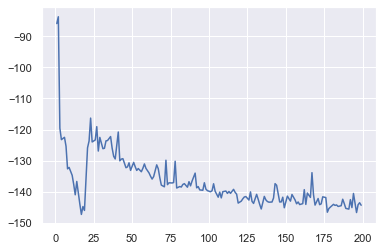

RuntimeError: CUDA out of memory. Tried to allocate 32.00 MiB (GPU 0; 6.00 GiB total capacity; 4.41 GiB already allocated; 0 bytes free; 4.51 GiB reserved in total by PyTorch)

In [21]:
valAcc = []
valF1 = []
valPrec = []
valRec = []
valF1basal = []
valAccTrans = []
valF1Trans = []
valF1KNN = []
valPrecKNN = []
valRecKNN = []
valAccKNN = []

for fold,(train_idx,test_idx) in enumerate(kfold.split(dataset)):
    xtrain,ytrain = dataset[train_idx]
    xtest,ytest = dataset[test_idx]
    N = ytrain.shape[0]
    
    # Network
    #decoder_human = Decoder(model_params['latent_dim'],model_params['decoder_1_hiddens'],gene_size,
    #                        dropRate=model_params['dropout_decoder'], 
    #                        activation=model_params['decoder_activation']).to(device)
    #decoder_mouse = Decoder(model_params['latent_dim'],model_params['decoder_2_hiddens'],gene_size,
    #                        dropRate=model_params['dropout_decoder'], 
    #                        activation=model_params['decoder_activation']).to(device)
    encoder_human = SimpleEncoder(gene_size,model_params['encoder_1_hiddens'],model_params['latent_dim'],
                                  dropRate=model_params['dropout_encoder'], 
                                  activation=model_params['encoder_activation'],
                                  normalizeOutput=True).to(device)
    encoder_mouse = SimpleEncoder(gene_size,model_params['encoder_2_hiddens'],model_params['latent_dim'],
                                  dropRate=model_params['dropout_encoder'], 
                                  activation=model_params['encoder_activation'],
                                  normalizeOutput=True).to(device)
    prior_d = PriorDiscriminator(model_params['latent_dim']).to(device)
    local_d = LocalDiscriminator(model_params['latent_dim'],model_params['latent_dim']).to(device)
    
    classifier = Classifier(in_channel=model_params['latent_dim'],
                            hidden_layers=model_params['state_class_hidden'],
                            num_classes=model_params['no_states'],
                            drop_in=model_params['state_class_drop_in'],
                            drop=model_params['state_class_drop']).to(device)
    adverse_classifier = Classifier(in_channel=model_params['latent_dim'],
                                    hidden_layers=model_params['adv_class_hidden'],
                                    num_classes=model_params['no_adv_class'],
                                    drop_in=model_params['adv_class_drop_in'],
                                    drop=model_params['adv_class_drop']).to(device)
    
    Vsp = SpeciesCovariate(2,model_params['latent_dim'],dropRate=model_params['V_dropout']).to(device)
    
    allParams = list(encoder_human.parameters()) +list(encoder_mouse.parameters())
    allParams = allParams + list(prior_d.parameters()) + list(local_d.parameters())
    allParams = allParams + list(classifier.parameters())
    allParams = allParams + list(Vsp.parameters())
    optimizer = torch.optim.Adam(allParams, lr= model_params['encoding_lr'], weight_decay=0)
    optimizer_adv = torch.optim.Adam(adverse_classifier.parameters(), lr= model_params['adv_lr'], weight_decay=0)
    if model_params['schedule_step_adv'] is not None:
        scheduler_adv = torch.optim.lr_scheduler.StepLR(optimizer_adv,
                                                        step_size=model_params['schedule_step_adv'],
                                                        gamma=model_params['gamma_adv'])
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=model_params['schedule_step_enc'],
                                                gamma=model_params['gamma_enc'])
    trainLoss = []
    train_eps = []
    f1_basal_trained = None
    for e in range(0, NUM_EPOCHS):
        encoder_human.train()
        encoder_mouse.train()
        prior_d.train()
        local_d.train()
        classifier.train()
        adverse_classifier.train()
        Vsp.train()
        
        trainloader = getSamples(N, bs)
        iteration = 1
        
        for dataIndex in trainloader:
            dataIn = xtrain[dataIndex]
            true_categories = ytrain[dataIndex]
            ind_humans = torch.where(true_categories[:,1]==1)[0]
            ind_mouse = torch.where(true_categories[:,1]!=1)[0]
            X_human = dataIn[ind_humans,:].to(device)
            X_mouse = dataIn[ind_mouse,:].to(device)
            Y_human = true_categories[ind_humans,0]
            Y_mouse = true_categories[ind_mouse,0]
            conds_human = true_categories[ind_humans,2]
            conds_mouse = true_categories[ind_mouse,2]
            
            
            z_species_1 = torch.cat((torch.ones(X_human.shape[0],1),
                                     torch.zeros(X_human.shape[0],1)),1).to(device)
            z_species_2 = torch.cat((torch.zeros(X_mouse.shape[0],1),
                                     torch.ones(X_mouse.shape[0],1)),1).to(device)
            
            conditions_disease = np.concatenate((Y_human.numpy(),Y_mouse.numpy()))
            size = conditions_disease.size
            conditions_disease = conditions_disease.reshape(size,1)
            conditions_disease = conditions_disease == conditions_disease.transpose()
            conditions_disease = conditions_disease*1

            conditions_cell = np.concatenate((conds_human.numpy(),conds_mouse.numpy()))
            size = conditions_cell.size
            conditions_cell = conditions_cell.reshape(size,1)
            conditions_cell = conditions_cell == conditions_cell.transpose()
            conditions_cell = conditions_cell*1

            conditions = np.multiply(conditions_disease,conditions_cell)
            mask = torch.tensor(conditions).to(device).detach()
            #mask = torch.tensor(conditions_cell).to(device).detach()
            pos_mask = mask
            neg_mask = 1 - mask
            log_2 = math.log(2.)
            
            optimizer.zero_grad()
            optimizer_adv.zero_grad()
                        
            if e % model_params["adversary_steps"]  == 0:            
                z_base_1 = encoder_human(X_human)
                z_base_2 = encoder_mouse(X_mouse)
                latent_base_vectors = torch.cat((z_base_1, z_base_2), 0)
                labels_adv = adverse_classifier(latent_base_vectors)
                true_labels = torch.cat((torch.ones(z_base_1.shape[0]),
                                         torch.zeros(z_base_2.shape[0])),0).long().to(device)
                adv_entropy = class_criterion(labels_adv,true_labels)
                adversary_drugs_penalty = compute_gradients(labels_adv.sum(), latent_base_vectors)
                loss_adv = adv_entropy + model_params['adv_penalnty'] * adversary_drugs_penalty
                loss_adv.backward()
                optimizer_adv.step()
                _, predicted = torch.max(labels_adv, 1)
                predicted = predicted.cpu().numpy()
                cf_matrix = confusion_matrix(true_labels.cpu(),predicted)
                tn, fp, fn, tp = cf_matrix.ravel()
                f1_basal_trained = 2*tp/(2*tp+fp+fn)
            else:
                z_base_1 = encoder_human(X_human)
                z_base_2 = encoder_mouse(X_mouse)
                latent_base_vectors = torch.cat((z_base_1, z_base_2), 0)
            
                z_un = local_d(latent_base_vectors)
                res_un = torch.matmul(z_un, z_un.t())
            
                z_1 = Vsp(z_base_1,z_species_1)
                z_2 = Vsp(z_base_2,z_species_2)
                latent_vectors = torch.cat((z_1, z_2), 0)
            
                silimalityLoss = torch.sum(torch.cdist(latent_base_vectors,latent_base_vectors)[mask==1])/torch.sum(mask==1)
                cosineLoss = torch.mean(torch.matmul(torch.cat((z_base_1, z_base_2), 0),
                                                     torch.cat((z_base_1, z_base_2), 0).t())[mask==1])
            
                p_samples = res_un * pos_mask.float()
                q_samples = res_un * neg_mask.float()

                Ep = log_2 - F.softplus(- p_samples)
                Eq = F.softplus(-q_samples) + q_samples - log_2

                Ep = (Ep * pos_mask.float()).sum() / pos_mask.float().sum()
                Eq = (Eq * neg_mask.float()).sum() / neg_mask.float().sum()
                mi_loss = Eq - Ep

                #prior = torch.rand_like(torch.cat((z_1, z_2), 0))
                prior = torch.rand_like(latent_base_vectors)

                term_a = torch.log(prior_d(prior)).mean()
                #term_b = torch.log(1.0 - prior_d(torch.cat((z_1, z_2), 0))).mean()
                term_b = torch.log(1.0 - prior_d(latent_base_vectors)).mean()
                prior_loss = -(term_a + term_b) * model_params['prior_beta']

                # Classification loss
                labels = classifier(latent_vectors)
                true_labels = torch.cat((Y_human,Y_mouse),0).long().to(device)
                entropy = class_criterion(labels,true_labels)
                _, predicted = torch.max(labels, 1)
                predicted = predicted.cpu().numpy()
                cf_matrix = confusion_matrix(true_labels.cpu(),predicted)
                tn, fp, fn, tp = cf_matrix.ravel()
                acc = (tp+tn)/predicted.size
                f1 = 2*tp/(2*tp+fp+fn)
            
                # Remove signal from z_basal
                labels_adv = adverse_classifier(latent_base_vectors)
                true_labels = torch.cat((torch.ones(z_base_1.shape[0]),
                                         torch.zeros(z_base_2.shape[0])),0).long().to(device)
                adv_entropy = class_criterion(labels_adv,true_labels)
                _, predicted = torch.max(labels_adv, 1)
                predicted = predicted.cpu().numpy()
                cf_matrix = confusion_matrix(true_labels.cpu().numpy(),predicted)
                tn, fp, fn, tp = cf_matrix.ravel()
                f1_basal = 2*tp/(2*tp+fp+fn)
            
                loss = model_params['lambda_mi_loss']*mi_loss + prior_loss  +\
                       model_params['reg_state'] * entropy - model_params['reg_adv']*adv_entropy +\
                       model_params['similarity_reg'] * silimalityLoss - model_params['cosine_reg'] * cosineLoss+\
                       classifier.L2Regularization(model_params['state_class_reg']) +\
                       Vsp.Regularization(model_params['v_reg']) +\
                       encoder_human.L2Regularization(model_params['enc_l2_reg']) +\
                       encoder_mouse.L2Regularization(model_params['enc_l2_reg'])
                loss.backward()
                optimizer.step()
                #iteration += 1
        
        if model_params['schedule_step_adv'] is not None:
            scheduler_adv.step()
        if (e>0):
            scheduler.step()
            outString = 'Split {:.0f}: Epoch={:.0f}/{:.0f}'.format(fold+1,e+1,NUM_EPOCHS)
            outString += ', MI Loss={:.4f}'.format(mi_loss.item())
            outString += ', Prior Loss={:.4f}'.format(prior_loss.item())
            outString += ', Entropy Loss={:.4f}'.format(entropy.item())
            outString += ', Adverse Entropy={:.4f}'.format(adv_entropy.item())
            outString += ', loss={:.4f}'.format(loss.item())
            outString += ', Accuracy_latent={:.4f}'.format(acc)
            outString += ', F1_latent={:.4f}'.format(f1)
            outString += ', F1 basal={:.4f}'.format(f1_basal)
            if f1_basal_trained is not None:
                outString += ', F1 basal trained={:.4f}'.format(f1_basal_trained)
        if ((e%10==0 and e>0) or e==1):
            print(outString)
        if e % model_params['adversary_steps'] !=0:
            trainLoss.append(loss.item())
            train_eps.append(e)
    print(outString)
    
    encoder_human.eval()
    encoder_mouse.eval()
    prior_d.eval()
    local_d.eval()
    classifier.eval()
    adverse_classifier.eval()
    Vsp.eval()
    
    ind_humans = torch.where(ytest[:,1]==1)[0]
    ind_mouse = torch.where(ytest[:,1]!=1)[0]
    X_human = xtest[ind_humans,:].to(device)
    X_mouse = xtest[ind_mouse,:].to(device)
    Y_human = ytest[ind_humans,0]
    Y_mouse = ytest[ind_mouse,0]
    
    z_species_1 = torch.cat((torch.ones(X_human.shape[0],1),
                             torch.zeros(X_human.shape[0],1)),1).to(device)
    z_species_2 = torch.cat((torch.zeros(X_mouse.shape[0],1),
                             torch.ones(X_mouse.shape[0],1)),1).to(device)
    
    z_latent_base_1 = encoder_human(X_human)
    z_latent_base_2 = encoder_mouse(X_mouse)
    
    z1 = Vsp(z_latent_base_1,z_species_1)
    z2 = Vsp(z_latent_base_2,z_species_2)
    
    # Classification
    test_out = classifier(torch.cat((z1, z2), 0))
    true_labels = torch.cat((Y_human,Y_mouse),0).long().to(device)
    _, predicted = torch.max(test_out, 1)
    predicted = predicted.cpu().numpy()
    cf_matrix = confusion_matrix(true_labels.cpu().numpy(),predicted)
    tn, fp, fn, tp = cf_matrix.ravel()
    acc = (tp+tn)/predicted.size
    rec = tp/(tp+fn)
    prec = tp/(tp+fp)
    f1 = 2*tp/(2*tp+fp+fn)
    
    labels_adv = adverse_classifier(torch.cat((z_latent_base_1, z_latent_base_2), 0))
    true_labels = torch.cat((torch.ones(z_latent_base_1.shape[0]),
                                     torch.zeros(z_latent_base_2.shape[0])),0).long().to(device)
    _, predicted = torch.max(labels_adv, 1)
    predicted = predicted.cpu().numpy()
    cf_matrix = confusion_matrix(true_labels.cpu().numpy(),predicted)
    tn, fp, fn, tp = cf_matrix.ravel()
    f1_basal = 2*tp/(2*tp+fp+fn)
    
    #pearson_1 = pearson_r(x1.detach().flatten(), X_human.detach().flatten())
    #r2_1 = r_square(x1.detach().flatten(), X_human.detach().flatten())        
    #pearson_2 = pearson_r(x2.detach().flatten(), X_mouse.detach().flatten())
    #r2_2 = r_square(x2.detach().flatten(), X_mouse.detach().flatten())
    
    # Translate to other species
    ind_humans_train = torch.where(ytrain[:,1]==1)[0]
    ind_mouse_train = torch.where(ytrain[:,1]!=1)[0]
    X_human = xtrain[ind_humans_train,:]
    X_mouse = xtrain[ind_mouse_train,:]
    z_species_train_1 = torch.cat((torch.ones(X_human.shape[0],1),
                             torch.zeros(X_human.shape[0],1)),1).to(device)
    z_species_train_2 = torch.cat((torch.zeros(X_mouse.shape[0],1),
                             torch.ones(X_mouse.shape[0],1)),1).to(device)
    z_train_base_1 = torch.zeros(X_human.shape[0],model_params['latent_dim'])
    z_train_base_2 = torch.zeros(X_mouse.shape[0],model_params['latent_dim'])
    z1_train = torch.zeros(X_human.shape[0],model_params['latent_dim'])
    z2_train = torch.zeros(X_mouse.shape[0],model_params['latent_dim'])
    val_bs_1 = 1024
    val_bs_2 = 1024
    ii=0
    jj=0
    while (ii<X_human.shape[0]):
        if (ii+val_bs_1>X_human.shape[0]):
            z_train_base_1[ii:,:] =  encoder_human(X_human[ii:,:].to(device)).cpu()
            z1_train[ii:,:] = Vsp(z_train_base_1[ii:,:].to(device),
                                  z_species_train_1[ii:,:]).cpu()
        else:
            z_train_base_1[ii:(ii+val_bs_1),:] =  encoder_human(X_human[ii:(ii+val_bs_1),:].to(device)).cpu()
            z1_train[ii:(ii+val_bs_1),:]  = Vsp(z_train_base_1[ii:(ii+val_bs_1),:].to(device),
                                                z_species_train_1[ii:(ii+val_bs_1),:]).cpu()
        ii = ii + val_bs_1
    
    while (jj<X_mouse.shape[0]):
        if (jj+val_bs_2>X_mouse.shape[0]):
            z_train_base_2[jj:,:] =  encoder_mouse(X_mouse[jj:,:].to(device)).cpu()
            z2_train[jj:,:] = Vsp(z_train_base_2[jj:,:].to(device),
                                  z_species_train_2[jj:,:]).cpu()
        else:
            z_train_base_2[jj:(jj+val_bs_2),:] =  encoder_mouse(X_mouse[jj:(jj+val_bs_2),:].to(device)).cpu()
            z2_train[jj:(jj+val_bs_2),:] = Vsp(z_train_base_2[jj:(jj+val_bs_2),:].to(device),
                                               z_species_train_2[jj:(jj+val_bs_2),:]).cpu()
        jj = jj + val_bs_2
    
    knn = KNeighborsClassifier(n_neighbors=5,metric = 'cosine')
    knn.fit(torch.cat((z1_train,z2_train),0).detach().numpy(), np.concatenate((np.ones(z1_train.shape[0]),
                                                                     np.zeros(z2_train.shape[0])),0))
    
    z1_translated = Vsp(z_latent_base_2,1 - z_species_2)
    z2_translated = Vsp(z_latent_base_1,1 - z_species_1)
    y_pred_translated = knn.predict(torch.cat((z1_translated,z2_translated),0).detach().cpu().numpy())
    cf_matrix = confusion_matrix(np.concatenate((np.ones(z1_translated.shape[0]),np.zeros(z2_translated.shape[0])),0),
                                 y_pred_translated)
    tn, fp, fn, tp = cf_matrix.ravel()
    acc_translation = (tp+tn)/y_pred_translated.size
    rec_translation = tp/(tp+fn)
    prec_translation = tp/(tp+fp)
    f1_translation = 2*tp/(2*tp+fp+fn)
    
    #knn performance in the validation set
    y_pred = knn.predict(torch.cat((z1,z2),0).detach().cpu().numpy())
    cf_matrix = confusion_matrix(np.concatenate((np.ones(z1.shape[0]),np.zeros(z2.shape[0])),0),
                                 y_pred)
    tn, fp, fn, tp = cf_matrix.ravel()
    acc_knn = (tp+tn)/y_pred.size
    rec_knn = tp/(tp+fn)
    prec_knn = tp/(tp+fp)
    f1_knn = 2*tp/(2*tp+fp+fn)
    
    outString = 'Validation-set performance: Fold={:.0f}'.format(fold)
    outString += ', Accuracy={:.4f}'.format(acc)
    outString += ', F1 score={:.4f}'.format(f1)
    outString += ', Precision={:.4f}'.format(prec)
    outString += ', Recall={:.4f}'.format(rec)
    outString += ', F1 score basal={:.4f}'.format(f1_basal)
    outString += ', Accuracy KNN={:.4f}'.format(acc_knn)
    outString += ', F1 score KNN={:.4f}'.format(f1_knn)
    outString += ', Accuracy translation={:.4f}'.format(acc_translation)
    outString += ', F1 translation={:.4f}'.format(f1_translation)
    
    valAcc.append(acc)
    valF1.append(f1)
    valPrec.append(prec)
    valRec.append(rec)
    valF1basal.append(f1_basal)
    valAccTrans.append(acc_translation)
    valF1Trans.append(f1_translation)
    valF1KNN.append(f1_knn)
    valPrecKNN.append(prec_knn)
    valRecKNN.append(rec_knn)
    valAccKNN.append(acc_knn)
    
    print(outString)
    plt.figure()
    plt.plot(train_eps,trainLoss)
    #plt.ylim(0,1)
    #plt.yscale('log')
    plt.show()
    
    torch.save(encoder_human,'models/encoder_human_%s.pth'%fold)
    torch.save(encoder_mouse,'models/encoder_mouse_%s.pth'%fold)
    torch.save(prior_d,'models/prior_d_%s.pth'%fold)
    torch.save(local_d,'models/local_d_%s.pth'%fold)
    torch.save(classifier,'models/classifier_disease_%s.pth'%fold)
    torch.save(Vsp,'models/Vspecies_%s.pt'%fold)
    torch.save(adverse_classifier,'models/classifier_adverse_%s.pt'%fold)
    
    valEmbs_human  = pd.DataFrame(z1.detach().cpu().numpy())
    valEmbs_human['diagnosis'] = Y_human.detach().cpu().numpy()
    valEmbs_human['cell_type'] = ytest[ind_humans,2]
    valEmbs_mouse = pd.DataFrame(z2.detach().cpu().numpy())
    valEmbs_mouse['diagnosis'] = Y_mouse.detach().cpu().numpy()
    valEmbs_mouse['cell_type'] = ytest[ind_mouse,2]
    
    valEmbs_human.to_csv('embs/validation/valEmbs_%s_human.csv'%fold)
    valEmbs_mouse.to_csv('embs/validation/valEmbs_%s_mouse.csv'%fold)
    
    valEmbs_base_human  = pd.DataFrame(z_latent_base_1.detach().cpu().numpy())
    valEmbs_base_human['diagnosis'] = Y_human.detach().cpu().numpy()
    valEmbs_base_human['cell_type'] = ytest[ind_humans,2]
    valEmbs_base_mouse = pd.DataFrame(z_latent_base_2.detach().cpu().numpy())
    valEmbs_base_mouse['diagnosis'] = Y_mouse.detach().cpu().numpy()
    valEmbs_base_mouse['cell_type'] = ytest[ind_mouse,2]
    
    valEmbs_base_human.to_csv('embs/validation/valEmbs_base_%s_human.csv'%fold)
    valEmbs_base_mouse.to_csv('embs/validation/valEmbs_base_%s_mouse.csv'%fold)
    
    trainEmbs_human  = pd.DataFrame(z1_train.detach().cpu().numpy())
    trainEmbs_human['diagnosis'] = ytrain[ind_humans_train,0].detach().cpu().numpy()
    trainEmbs_human['cell_type'] = ytrain[ind_humans_train,2]
    trainEmbs_mouse = pd.DataFrame(z2_train.detach().cpu().numpy())
    trainEmbs_mouse['diagnosis'] = ytrain[ind_mouse_train,0].detach().cpu().numpy()
    trainEmbs_mouse['cell_type'] = ytrain[ind_mouse_train,2]
    
    trainEmbs_human.to_csv('embs/train/trainEmbs_%s_human.csv'%fold)
    trainEmbs_mouse.to_csv('embs/train/trainEmbs_%s_mouse.csv'%fold)
    
    trainEmbs_base_human  = pd.DataFrame(z_train_base_1.detach().cpu().numpy())
    trainEmbs_base_human['diagnosis'] = ytrain[ind_humans_train,0].detach().cpu().numpy()
    trainEmbs_base_human['cell_type'] = ytrain[ind_humans_train,2]
    trainEmbs_base_mouse = pd.DataFrame(z_train_base_2.detach().cpu().numpy())
    trainEmbs_base_mouse['diagnosis'] = ytrain[ind_mouse_train,0].cpu().numpy()
    trainEmbs_base_mouse['cell_type'] = ytrain[ind_mouse_train,2]
    
    trainEmbs_base_human.to_csv('embs/train/trainEmbs_base_%s_human.csv'%fold)
    trainEmbs_base_mouse.to_csv('embs/train/trainEmbs_base_%s_mouse.csv'%fold)

In [ ]:
# loss = model_params['lambda_mi_loss']*mi_loss + prior_loss  +\
#                        model_params['reg_state'] * entropy - model_params['reg_adv']*adv_entropy +\
#                        model_params['similarity_reg'] * silimalityLoss - model_params['cosine_reg'] * cosineLoss+\
#                        classifier.L2Regularization(model_params['state_class_reg']) +\
#                        Vsp.Regularization(model_params['v_reg']) +\
#                        encoder_human.L2Regularization(model_params['enc_l2_reg']) +\
#                        encoder_mouse.L2Regularization(model_params['enc_l2_reg'])

In [ ]:
results = pd.DataFrame({'Accuracy':valAcc,'F1':valF1,'Precision':valPrec,'Recall':valRec,
                        'BasalF1':valF1basal,'TranslationAccuracy':valAccTrans,'TranslationF1':valF1Trans})
results.to_csv('10foldvalidationResults.csv')
results